In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image # Sometimes useful with pytesseract


In [24]:
def display_image(img, title="Image", cmap=None, figsize=(10, 10)):
    """Displays an image using matplotlib."""
    plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        # Convert BGR (OpenCV default) to RGB for matplotlib
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray') # Keep grayscale if it's already gray
    plt.title(title)
    plt.axis('off')
    plt.show()

def draw_boxes(image, boxes, color=(0, 255, 0), thickness=2):
    """Draws bounding boxes on a copy of the image."""
    output_image = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(output_image, (x, y), (x + w, y + h), color, thickness)
    return output_image


--- Running Technique 2: CCA + Merging ---
Technique 2 found 82 potential word boxes after CCA merging.


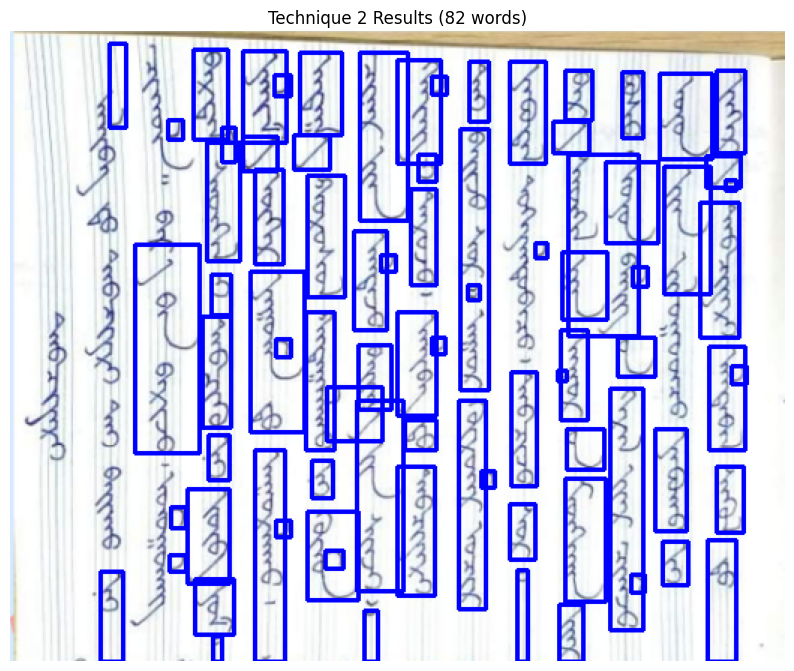

In [28]:
print("\n--- Running Technique 2: CCA + Merging ---")

# --- Tunable Parameters ---
# Initial component filtering (likely character parts)
min_comp_width = 5
max_comp_width = 100 # Adjust
min_comp_height = 5
max_comp_height = 100 # Adjust

# Merging thresholds (VERY sensitive for vertical script)
# Max horizontal distance between components to be considered in the same word column
MAX_CCA_HORIZ_DIST = 40 # Adjust based on column width / component width
# Max vertical gap allowed between components to merge into one word
MAX_CCA_VERT_GAP = 25   # Adjust based on line spacing within words vs between words
# ---

# Find connected components and stats
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

component_boxes = []
# Skip label 0 (background)
for i in range(1, num_labels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    # Filter initial components
    if min_comp_width < w < max_comp_width and min_comp_height < h < max_comp_height:
         component_boxes.append((x, y, w, h))

# Sort component boxes: Primarily by X (column), then by Y (top-down within column)
component_boxes.sort(key=lambda b: (b[0], b[1]))

# Merge components into words
cca_merged_boxes = []
if component_boxes:
    current_word_box = list(component_boxes[0])

    for i in range(1, len(component_boxes)):
        prev_box = current_word_box
        current_comp = component_boxes[i]

        px, py, pw, ph = prev_box
        cx, cy, cw, ch = current_comp

        # Check horizontal proximity (are they likely in the same column?)
        # Simple check: absolute difference in 'x' is small
        horizontal_dist = abs(cx - px)
        # More robust might involve checking center x or overlap, but start simple
        is_horizontally_close = horizontal_dist < MAX_CCA_HORIZ_DIST

        # Check vertical proximity (are they close enough vertically to be the same word?)
        # Simple check: gap between bottom of prev and top of current is small
        vertical_gap = cy - (py + ph)
        is_vertically_close = 0 <= vertical_gap < MAX_CCA_VERT_GAP

        if is_horizontally_close and is_vertically_close:
            # Merge: Extend the current_word_box to include the current_comp
            new_x = min(px, cx)
            new_y = min(py, cy)
            new_w = max(px + pw, cx + cw) - new_x
            new_h = max(py + ph, cy + ch) - new_y
            current_word_box = [new_x, new_y, new_w, new_h]
        else:
            # Not part of the same word, finalize the previous word
            cca_merged_boxes.append(tuple(current_word_box))
            # Start a new word with the current component
            current_word_box = list(current_comp)

    # Add the last processed word
    cca_merged_boxes.append(tuple(current_word_box))

print(f"Technique 2 found {len(cca_merged_boxes)} potential word boxes after CCA merging.")

# Visualize results
image_path = "data/mine.png"
image = cv2.imread(image_path)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Kernel 2: Stronger sharpening
# kernel_sharpen_2 = np.array([[-1, -1, -1],
#                                 [-1, 10, -1],
#                                 [-1, -1, -1]])
# kernel_sharpen_3 = np.array([[0, -1, 0],
#                                  [-1, 5, -1],
#                                  [0, -1, 0]])
# sharpened_2 = cv2.filter2D(gray, -1, kernel_sharpen_2)

img_cca_result = draw_boxes(image, cca_merged_boxes, color=(255, 0, 0)) # Red boxes
display_image(img_cca_result, title=f"Technique 2 Results ({len(cca_merged_boxes)} words)")


In [26]:
cv2.imwrite("data/test.png", sharpened_2)

True

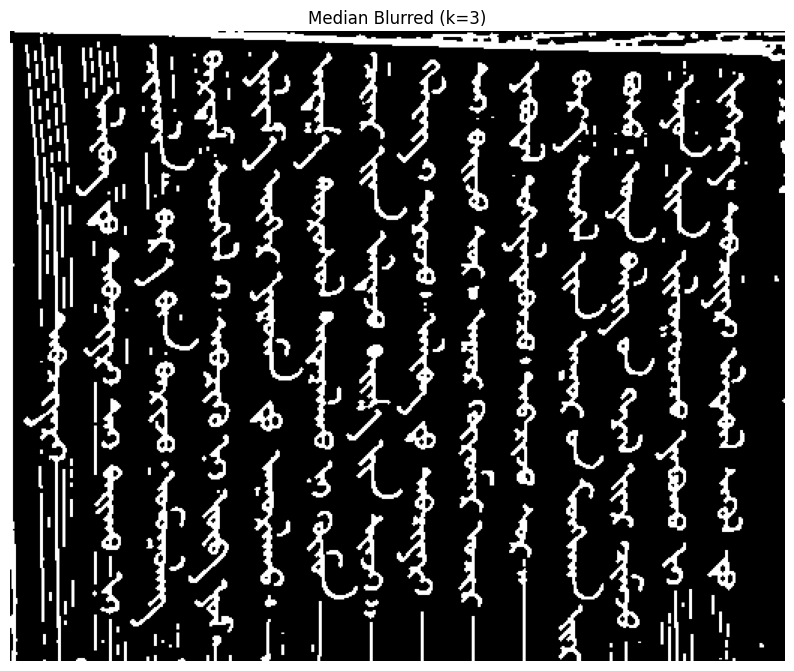

In [15]:
median_ksize = 3 # Must be odd (e.g., 3 or 5)
# ---

gray = binary
median_blurred = cv2.medianBlur(gray, median_ksize)
display_image(median_blurred, title=f"Median Blurred (k={median_ksize})", cmap='gray')


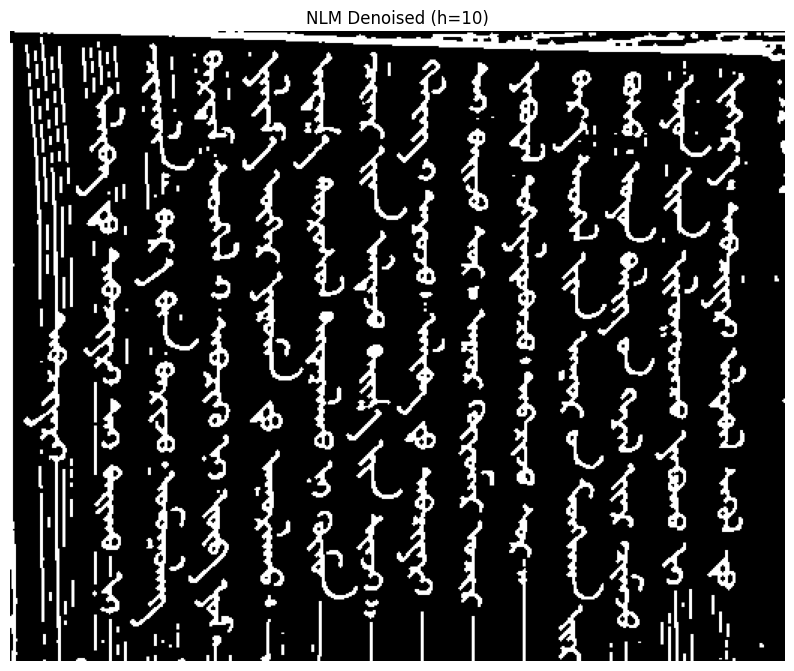

In [16]:
nlm_h = 10          # Filter strength. Higher values remove more noise but might blur details.
nlm_template_win = 7 # Must be odd.
nlm_search_win = 21  # Must be odd.
# ---
nlm_denoised = cv2.fastNlMeansDenoising(median_blurred, None, h=nlm_h,
                                         templateWindowSize=nlm_template_win,
                                         searchWindowSize=nlm_search_win)
display_image(nlm_denoised, title=f"NLM Denoised (h={nlm_h})", cmap='gray')

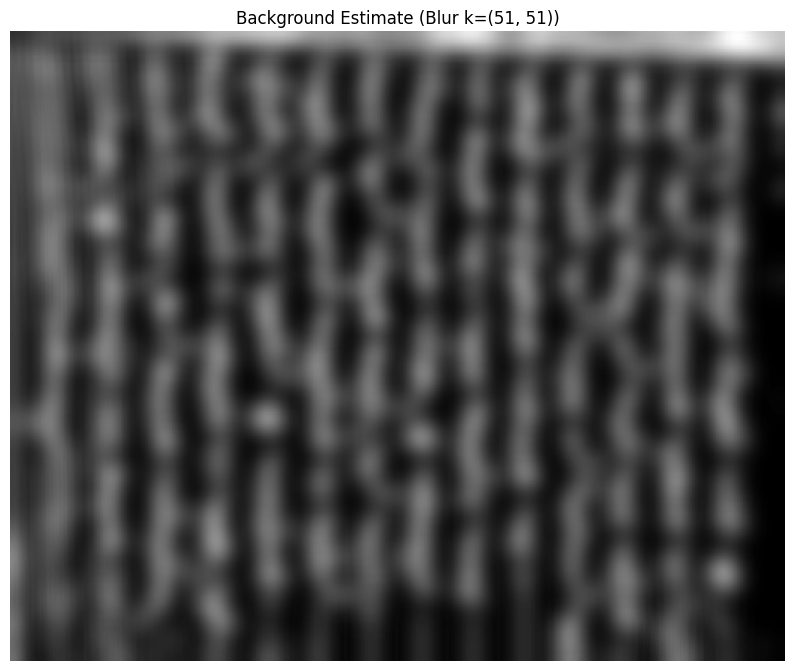

In [19]:
bg_blur_ksize = (51, 51) # Large kernel size (must be odd) to capture background variation
# ---
# Use the denoised image if available, otherwise grayscale
input_img_for_bg = nlm_denoised if 'nlm_denoised' in locals() else gray

background_estimate = cv2.GaussianBlur(input_img_for_bg, bg_blur_ksize, 0)
# background_estimate = cv2.medianBlur(input_img_for_bg, 51) # Alternative: Large Median Blur
display_image(background_estimate, title=f"Background Estimate (Blur k={bg_blur_ksize})", cmap='gray')


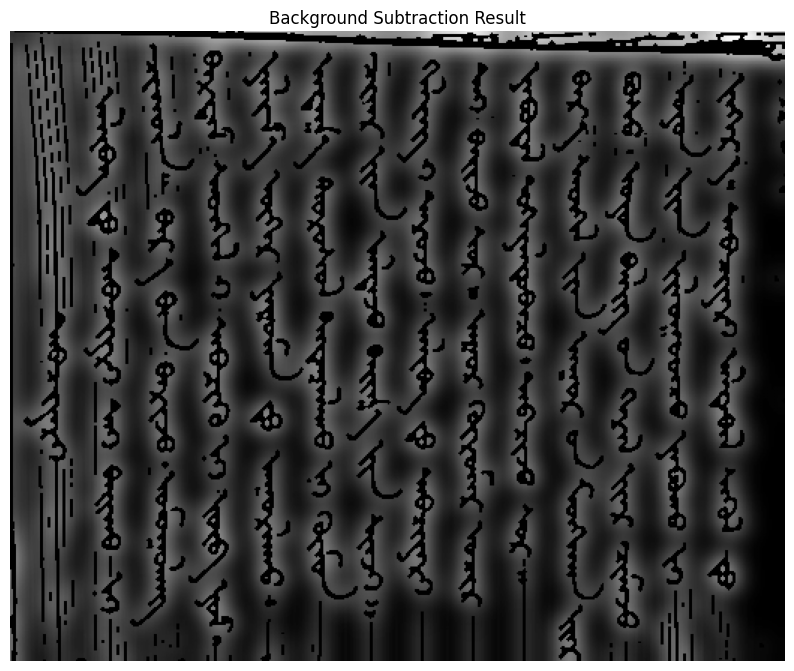

In [20]:
subtracted = cv2.subtract(background_estimate, input_img_for_bg)
# Optional: Invert if you expect white text after subtraction
# subtracted = cv2.bitwise_not(subtracted)
display_image(subtracted, title="Background Subtraction Result", cmap='gray')